In [66]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [67]:
repo_root = Path.cwd().parent

In [68]:
"""
Calcula estadisticas de cambio por zona .
"""
def analisis_zonal_cambios(ruta_cambios, ruta_zonas, columna_zona = 'NOM_ZONA'):
    # Cargar zonas
    zonas = gpd.read_file(ruta_zonas)

    with rasterio.open(ruta_cambios) as src:
        zonas = zonas.to_crs(src.crs)
    
    # Estadisticas zonales
    stats = zonal_stats(
        zonas,
        ruta_cambios,
        stats = ['count', 'sum', 'mean'],
        categorical = True,
        category_map = {0: 'sin_cambio', 1: 'urbanizacion', 2: 'perdida_veg', 3: 'ganancia_veg'}
    )

    # Convertir a DataFrame
    df_stats = pd.DataFrame(stats)
    df_stats['zona'] = zonas[columna_zona]

    # Agrega la geometria
    df_stats = gpd.GeoDataFrame(df_stats, geometry=zonas.geometry, crs=zonas.crs)

    # Calcular porcentajes
    total_pixeles = df_stats[['sin_cambio', 'urbanizacion', 'perdida_veg', 'ganancia_veg']].sum(axis=1)
                               
    for col in ['urbanizacion', 'perdida_veg', 'ganancia_veg']:
        df_stats[f'{col}_pct'] = 100 * df_stats[col] / total_pixeles

    # Calcular area ( asumiendo 10m x 10m = 100 m2 por pixel )
    pixel_area_ha = 100 / 10000 # hectareas
    for col in ['urbanizacion', 'perdida_veg', 'ganancia_veg']:
        df_stats[f'{col}_ha'] = df_stats[col] * pixel_area_ha
    
    return df_stats

# Ejecutar analisis
resultados = analisis_zonal_cambios(
    repo_root / 'data' / 'processed' / 'cambio_clasificado.tif',
    repo_root / 'data' / 'vector' / 'manzanas_censales.shp',
    columna_zona ='MANZENT'
)

# Resumen
print("\n=== RESUMEN DE CAMBIOS POR ZONA ===")
print(f" Total urbanizacion : { resultados['urbanizacion_ha'].sum() :.1f}ha")
print(f" Total perdida vegetacion : { resultados['perdida_veg_ha'].sum() :.1f}ha")
print(f" Total ganancia vegetacion : { resultados['ganancia_veg_ha'].sum() :.1f}ha")


=== RESUMEN DE CAMBIOS POR ZONA ===
 Total urbanizacion : 57.7ha
 Total perdida vegetacion : 54.8ha
 Total ganancia vegetacion : 63.2ha


#### Top 10 zonas con mayor urbanización


Top 10 zonas con mayor urbanizacion :
               zona  urbanizacion_ha
524  13106081001001             5.32
581  13106071003054             3.15
400  13106121002002             2.92
624  13106021002901             1.89
325  13106081004011             1.58
15   13106081006002             1.54
333  13106021001003             1.47
874  13106061004014             1.42
106  13106051002500             1.32
198  13106081003002             1.25


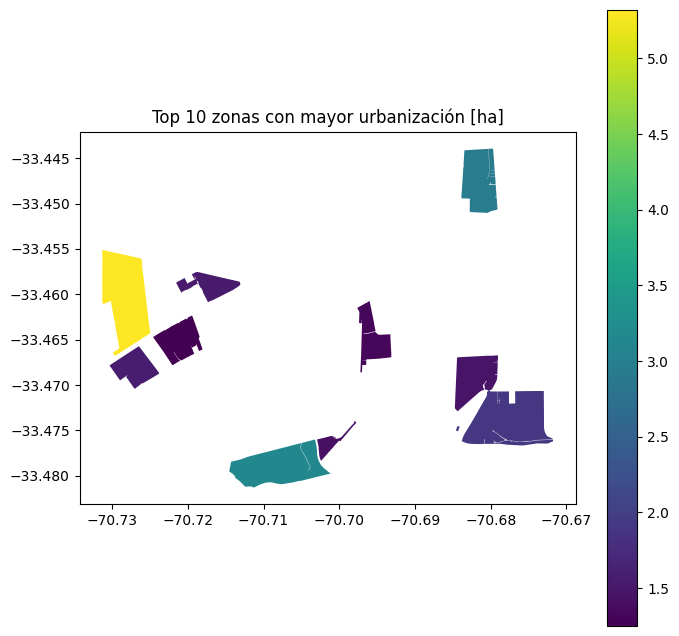

In [69]:
top = resultados.nlargest(10, 'urbanizacion_ha')

ax = top.plot(
    column='urbanizacion_ha',
    legend=True,
    figsize=(8,8)
)
ax.set_title("Top 10 zonas con mayor urbanización [ha]")

print("\nTop 10 zonas con mayor urbanizacion :")
print(top[['zona', 'urbanizacion_ha']])

#### Top 10 zonas con mayor perdida vegetal


Top 10 zonas con mayor perdida vegetal :
               zona  perdida_veg_ha
106  13106051002500            3.53
325  13106081004011            3.51
400  13106121002002            3.26
524  13106081001001            3.06
624  13106021002901            2.91
333  13106021001003            1.94
581  13106071003054            1.75
15   13106081006002            1.35
571  13106081002001            1.04
105  13106091001024            0.93


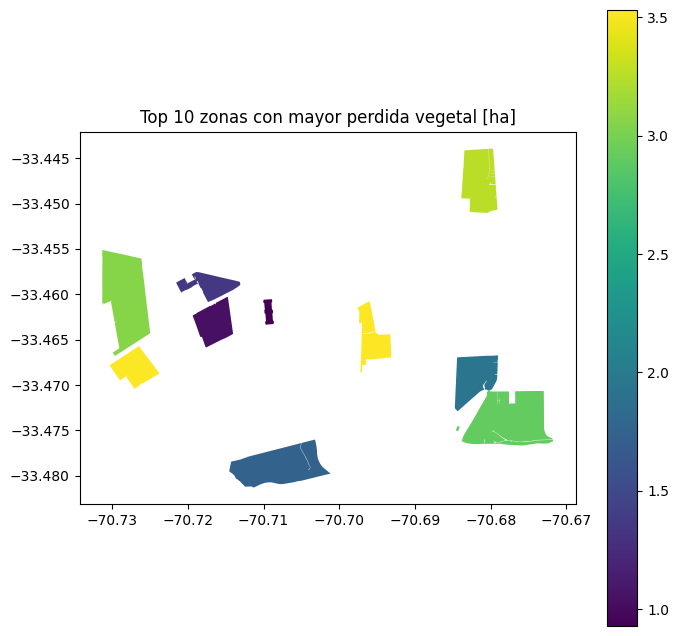

In [70]:
top = resultados.nlargest(10, 'perdida_veg_ha')

ax = top.plot(
    column='perdida_veg_ha',
    legend=True,
    figsize=(8,8)
)
ax.set_title("Top 10 zonas con mayor perdida vegetal [ha]")

print("\nTop 10 zonas con mayor perdida vegetal :")
print(top[['zona', 'perdida_veg_ha']])

#### Top 10 zonas con mayor ganancia vegetal


Top 10 zonas con mayor ganancia vegetal :
               zona  ganancia_veg_ha
524  13106081001001             9.15
333  13106021001003             2.88
445  13106011001008             2.30
624  13106021002901             2.18
290  13106081002003             2.14
400  13106121002002             1.55
198  13106081003002             1.31
581  13106071003054             1.02
571  13106081002001             0.96
37   13106101004022             0.81


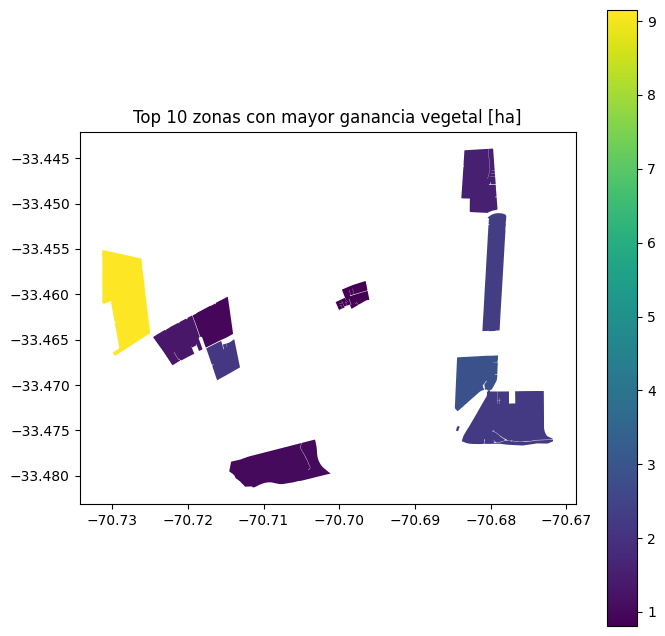

In [71]:
top = resultados.nlargest(10, 'ganancia_veg_ha')

ax = top.plot(
    column='ganancia_veg_ha',
    legend=True,
    figsize=(8,8)
)
ax.set_title("Top 10 zonas con mayor ganancia vegetal [ha]")

print("\nTop 10 zonas con mayor ganancia vegetal :")
print(top[['zona', 'ganancia_veg_ha']])

In [84]:
def analisis_temporal(fechas, mascara_area=None, output_dir="outputs"):
    """
    Analiza la evolución temporal de índices (NDVI y NDBI) en un área de estudio.
    """

    resultados = []

    for fecha in fechas:
        ruta = repo_root / 'data' / 'processed' / f"indices_{fecha}.tif"
        with rasterio.open(ruta) as src:
            ndvi = src.read(1).astype("float32")
            ndbi = src.read(2).astype("float32")

        if mascara_area is not None:
            ndvi = ndvi[mascara_area]
            ndbi = ndbi[mascara_area]

        resultados.append({
            "fecha": fecha,
            "ndvi_mean": np.nanmean(ndvi),
            "ndvi_std": np.nanstd(ndvi),
            "ndbi_mean": np.nanmean(ndbi),
            "ndbi_std": np.nanstd(ndbi),
            "pct_vegetacion": 100 * np.sum(ndvi > 0.3) / np.sum(~np.isnan(ndvi)),
            "pct_urbano": 100 * np.sum(ndbi > 0) / np.sum(~np.isnan(ndbi))
        })

    df = pd.DataFrame(resultados)

    # --------------------
    # Visualización
    # --------------------
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # NDVI temporal
    axes[0, 0].errorbar(
        df["fecha"], df["ndvi_mean"],
        yerr=df["ndvi_std"],
        marker="o", capsize=5
    )
    axes[0, 0].set_ylabel("NDVI medio")
    axes[0, 0].set_title("Evolución del NDVI")
    axes[0, 0].grid(True, alpha=0.3)

    # NDBI temporal
    axes[0, 1].errorbar(
        df["fecha"], df["ndbi_mean"],
        yerr=df["ndbi_std"],
        marker="s", capsize=5
    )
    axes[0, 1].set_ylabel("NDBI medio")
    axes[0, 1].set_title("Evolución del NDBI")
    axes[0, 1].grid(True, alpha=0.3)

    # Porcentaje vegetación
    axes[1, 0].bar(
        df["fecha"], df["pct_vegetacion"],
        alpha=0.7
    )
    axes[1, 0].set_ylabel("% área con vegetación")
    axes[1, 0].set_title("Cobertura de vegetación")

    # Porcentaje urbano
    axes[1, 1].bar(
        df["fecha"], df["pct_urbano"],
        alpha=0.7
    )
    axes[1, 1].set_ylabel("% área urbana")
    axes[1, 1].set_title("Cobertura urbana")

    plt.tight_layout()
    plt.savefig(Path(output_dir) / "evolucion_temporal.png", dpi=150)
    plt.close()

    return df


analisis_temporal([2018, 2020, 2022, 2024])

,fecha,ndvi_mean,ndvi_std,ndbi_mean,ndbi_std,pct_vegetacion,pct_urbano
0,2018,0.164159,0.137857,0.058769,0.101901,13.168278,78.070654
1,2020,0.155397,0.134806,0.055350,0.098628,12.046028,77.215054
2,2022,0.151342,0.128133,0.067782,0.098630,11.260015,79.856200
3,2024,0.160158,0.138807,0.066534,0.105220,13.384767,78.704670
